# The Convex Hull Problem

Pound a bunch of nails into a board, then stretch a rubber band around them and let the rubber band snap taut, like this:

<img src="http://www.personal.kent.edu/~rmuhamma/Compgeometry/MyCG/Gifs-CompGeometry/ch2.gif">

The rubber band has traced out the *convex hull* of the set of nails. It turns out this is an important problem with applications in computer graphics, robot motion planning, geographical information systems, ethology, and other areas.
More formally, we say that:

*Given a finite set, **P**, of points in a plane, the convex hull of **P** is a polygon, **H**, such that:*

- *Every point in **P** lies either on or inside of **H**.*
- *Every vertex of **H** is a point in **P**.*
- <i>**H**</i> *is convex: a line segment joining any two vertexes of **H** either is an edge of **H** or lies inside **H**.*


In this notebook we develop an algorithm to find the convex hull (and show examples of how to use `matplotlib` plotting). The first thing to do is decide how we will represent the objects of interest:

- **Point**: We'll define a class such that `Point(3, 4)` is a point where `p.x` is 3 and `p.y` is 4.
- **Set of Points**: We'll use a Python set: `{Point(0,0), Point(3,4), ...}`
- **Polygon**: We'll represent a polygon as an ordered list of vertex points.

First, get the necessary imports done:

In [1]:
from __future__ import division, print_function

%matplotlib inline 
import matplotlib.pyplot as plt
import collections
import random
import math

# Points and Sets of Points

I'll define the class `Point` as a named tuple of `x` and `y` coordinates, and `Points(n)` as a function that creates a set of *n* random points. 

There are two complications to the function `Points(n)`:
1. A second optional argument is used to set the random seed.  This way, the same call to `Points` will return the same result each time.  That makes it easier to reproduce tests.  If you want different sets of points, just pass in different values for the seed.
2. Since `matplotlib` plots on a 3&times;2 rectangle by default, the points will be uniformly sampled   from a 3&times;2 box (with a small border of 0.05 on each edge to prevent the points from bumping up against the edge of the box).

In [2]:
Point = collections.namedtuple('Point', 'x, y')

def Points(n, seed=42):
    "Generate n random points within a 3 x 2 box."
    random.seed((n, seed))
    b = 0.05 # border
    return {Point(random.uniform(b, 3-b), random.uniform(b, 2-b)) 
            for _ in range(n)}

In [3]:
Points(3)

{Point(x=0.15172583449638682, y=1.6108693392839208),
 Point(x=0.968326330695687, y=1.3139550880088586),
 Point(x=1.3508070075242857, y=0.22290610532132638)}

# Visualizing Points and Line Segments


Now let's see how to visualize points; I'll define a function `plot_points`.  We will want to be able to see:
- The **points** themselves. 
- Optionally, **line segments** between points. An optional `style` parameter allows you to specify whether you want lines or not, and what color they should be. This parameter uses the standard [style format](http://matplotlib.org/1.3.1/api/pyplot_api.html#matplotlib.pyplot.plot) defined by matplotlib; for example, `'r.'` means red colored dots with no lines, `'bs-'` means blue colored squares with lines between them, and `'go:'` means green colored circles with dotted lines between them.  The lines go from point to point in order; if you want the lines to close
back from the last point to the first (to form a complete polygon), specify `closed=True`. (For that to work,
the collection of points must be a list; with `closed=False` the collection can be any collection.)
- Optionally, **labels** on the points that let us distinguish one from another. You get
labels (integers from 0 to *n*) if you specify `labels=True`.

In [4]:
def plot_points(points, style='r.', labels=False, closed=False): 
    """Plot a collection of points. Optionally change the line style, label points with numbers, 
    and/or form a closed polygon by closing the line from the last point to the first."""
    if labels:
        for (i, (x, y)) in enumerate(points):
            plt.text(x, y, '  '+str(i))
    if closed:
        points = points + [points[0]]
    plt.plot([p.x for p in points], [p.y for p in points], style, linewidth=2.5)
    plt.axis('scaled'); plt.axis('off')

Here's an example:

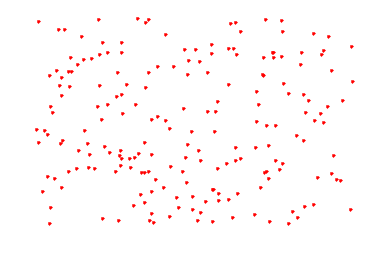

In [5]:
plot_points(Points(200))

# Convexity


We want to make a *convex* hull, so we better have some way of determining whether a polygon is *convex*. Let's examine one that is:

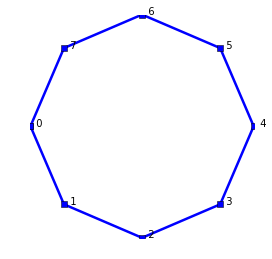

In [6]:
octagon = [Point(-10, 0), Point(-7, -7), Point(0, -10), Point(+7, -7), 
           Point(+10, 0), Point(+7, +7), Point(0, +10), Point(-7, 7)]
plot_points(octagon, 'bs-', labels=True, closed=True)

If you start at point 0 at the left and proceed in order counterclockwise around the octagon, following edges from point to point, you can see that at every vertex you are making a **left** turn.

Now let's consider a non-convex polygon:

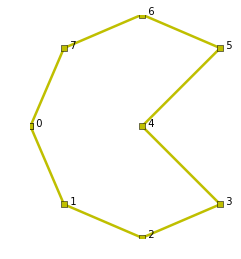

In [7]:
pacman = octagon[:4] + [Point(0, 0)] + octagon[5:]
plot_points(pacman, 'ys-', labels=True, closed=True)

The `pacman` polygon is non-convex; you can see that a line from point 3 to point 5 passes *outside* the polygon. You can also see that as you move counterclockwise from 3 to 4 to 5 you turn **right** at 4.  That leads to the idea: **a polygon is convex if there are no right turns** as we go around the polygon counterclockwise.  

# Turn Directions


Now how do we determine if a turn from point A to B to C is a left turn at B or a right turn (or straight)? Consider this diagram:

<img src="http://norvig.com/convexhull.jpg">

It is a left turn at B if angle &beta;  is bigger than angle &alpha;; in other words, if &beta;'s opposite-over-adjacent ratio is bigger than &alpha;'s: 

    (C.y - B.y) / (C.x - B.x)   >   (B.y - A.y) / (B.x - A.x)
    
But if we did that computation, we'd need special cases for when each denominator is zero.  So multiply each side by the denominators:

    (B.x - A.x) * (C.y - B.y)   >   (B.y - A.y) * (C.x - B.x) 
    
(*Note:* This step should make you very nervous! In general, multiplying both sides of an inequality by a negative number reverses the inequality, and here the denominators might be negative. In this case it works out; basically because we are doing two multiplications so that negatives cancel out, but [the math proof](https://en.wikipedia.org/wiki/Cross_product) is tricky, involving some concepts in vector algebra, so I won't duplicate it here; instead I will provide good test coverage below.)
    
That leads to the function definition: 

In [8]:
def turn(A, B, C):
    "Is the turn from A->B->C a 'right', 'left', or 'straight' turn?"
    diff = (B.x - A.x) * (C.y - B.y)  -  (B.y - A.y) * (C.x - B.x) 
    return ('right' if diff < 0 else
            'left'  if diff > 0 else
            'straight')

# Sketch of Convex Hull Algorithm


Now we have the first part of a strategy to find the convex hull:

> *Travel a path along the points in some order. (It is not yet clear exactly what order.) Any point along the way that does not mark a left-hand turn is not part of the hull.*

What's a good order? Let's see what happens if we start at the leftmost point and work our way to the rightmost.  We can achieve that ordering by calling the built-in function `sorted` on the points (since points are tuples, `sorted` sorts them lexicographically: first by their first component, `x`, and if there are ties, next by their `y` component). We start with 11 random points, and I will define a function to help plot the partial hull as we go:

In [9]:
def plot_partial_hull(points, hull_indexes=()):
    "Plot the points, labeled, with a blue line for the points named by indexes."
    plot_points(points, labels=True)
    plot_points([points[i] for i in hull_indexes], 'bs-')

Here are the points without any hull:

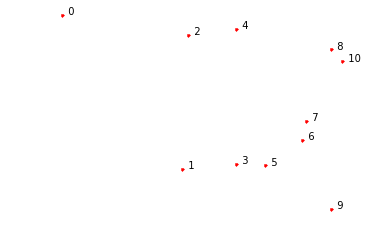

In [10]:
plot_partial_hull(sorted(Points(11)))

Now I will start building up the hull by following the points in order from point 0 to 1 to 2 to 3:

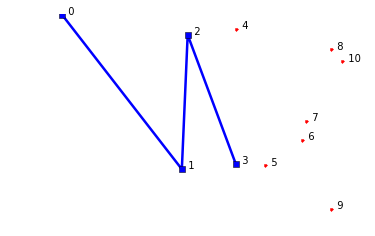

In [11]:
plot_partial_hull(sorted(Points(11)), [0, 1, 2, 3])

We see that we made a valid left turn at point 1, but a right turn at 2. So we remove point 2 from the hull:

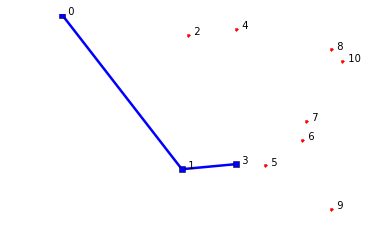

In [12]:
plot_partial_hull(sorted(Points(11)), [0, 1, 3])

We move on to points 4 and 5:

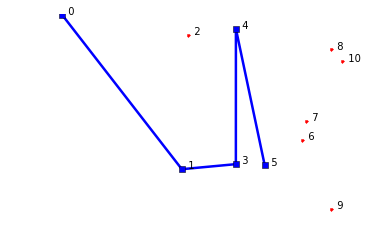

In [13]:
plot_partial_hull(sorted(Points(11)), [0, 1, 3, 4, 5])

Point 4 is a right turn, so we remove it:

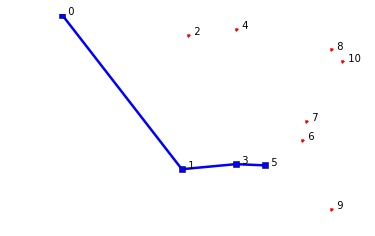

In [14]:
plot_partial_hull(sorted(Points(11)), [0, 1, 3, 5])

But now we see point 3 is also a right turn.  The addition of one new point (5) can remove multiple points (4 and 3) from the hull. We remove 3 and move on to 6, 7, and 8:

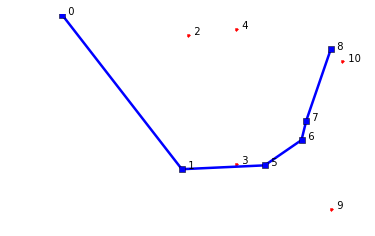

In [15]:
plot_partial_hull(sorted(Points(11)), [0, 1, 5, 6, 7, 8])

Point 7 is a right turn so we remove 7 and move on to 9:

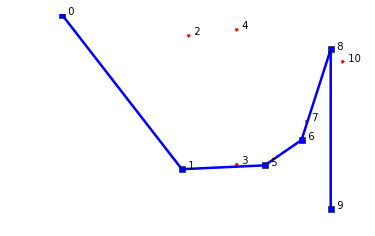

In [16]:
plot_partial_hull(sorted(Points(11)), [0, 1, 5, 6, 8, 9])

Point 8 is a right turn, so we remove 8.  But then 6 and 5 are also right turns, so they too are removed. We proceed on to 10:

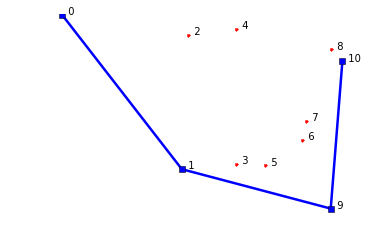

In [17]:
plot_partial_hull(sorted(Points(11)), [0, 1, 9, 10])

Now what do we do? We got all the way to the end of our set of 11 points, but we only got half the hull (the lower half).  Well, if looking at all the points in left-to-right order gives us the lower half of the hull, maybe looking at all the points in right-to-left order will give us the upper half.  Let's try. 

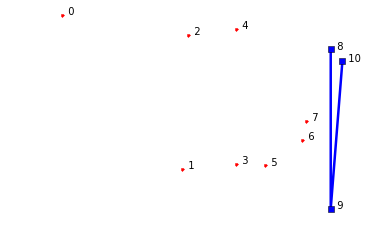

In [18]:
plot_partial_hull(sorted(Points(11)), [10, 9, 8])

Point 9 is a right turn; remove it and move on:

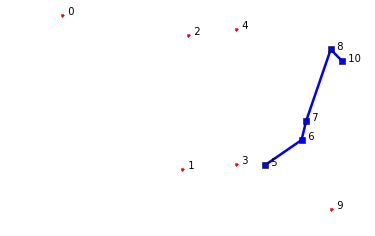

In [19]:
plot_partial_hull(sorted(Points(11)), [10, 8, 7, 6, 5])

Adding 5 reveals 6, and then 7, to be right turns; remove them and move on to 4:

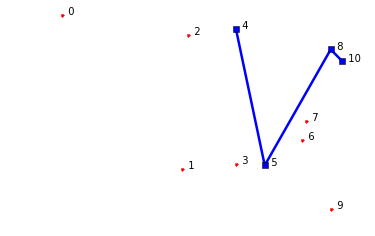

In [20]:
plot_partial_hull(sorted(Points(11)), [10, 8, 5, 4])

Remove 5 and continue on to 3 and then 2:

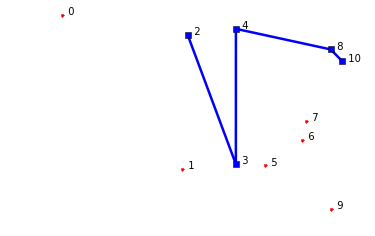

In [21]:
plot_partial_hull(sorted(Points(11)), [10, 8, 4, 3, 2])

Now 3 is a right turn; remove it and continue on to 1 and finally 0:

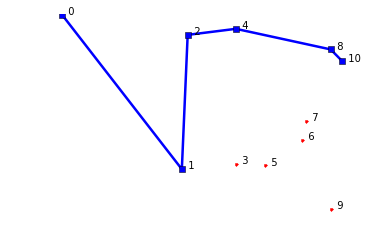

In [22]:
plot_partial_hull(sorted(Points(11)), [10, 8, 4, 2, 1 ,0])

Adding 0 makes,  1, and then  2 be right turns, so they are removed:

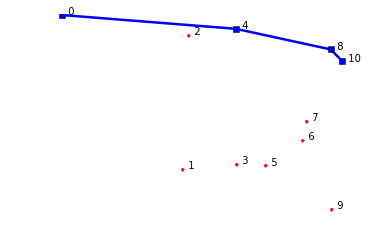

In [23]:
plot_partial_hull(sorted(Points(11)), [10, 8, 4, 0])

Let's bring back the lower hull and concatenate it with the upper hull:

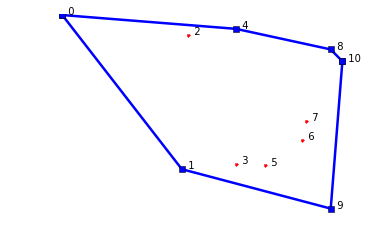

In [24]:
plot_partial_hull(sorted(Points(11)), [0, 1, 9, 10] + [10, 8, 4, 0])

That's all there is to the basic idea of the algorithm, but there are a few edge cases to worry about: 

* **Degenerate polygons**: What happens when there are only 1 or 2 (or zero) points? Such a set of points should be considered convex because there is no way to draw a line segment that goes outside the points.

* **Colinear points:** if three or more points are colinear, we should keep only the two "outside" ones.  The rationale for not keeping them all is that we want the convex hull to be the minimal possible set of points. We need to keep the outside ones because they mark true corners in the hull. We can achieve this by rejecting a point when it is a "straight" turn as well as when it is a "right" turn.

* **First and last points:** An astute reader might have noticed that our algorithm only rejects the middle point, point B, in the A->B->C turn. That means that the first and last point in sorted order will never be a candidate for rejection, and thus will always end up on the hull.  Is that correct?  Yes it is. The first point is the leftmost point, the one with lowest `x` value (and if there are ties, it is the lowest-leftmost point). That is an extreme corner, so it should always be on the hull. A similar argument holds for the last point in sorted order.




# Implementation of Convex Hull Algorithm

In [25]:
def convex_hull(points):
    "Find the convex hull of a set of points."
    if len(points) <= 3:
        return points
    # Find the two half-hulls and append them, but don't repeat first and last points
    upper = half_hull(sorted(points))
    lower = half_hull(reversed(sorted(points)))
    return upper + lower[1:-1]

def half_hull(sorted_points):
    "Return the half-hull from following points in sorted order."
    # Add each point C in order; remove previous point B if A->B-C is not a left turn.
    hull = []
    for C in sorted_points:
        # if A->B->C is not a left turn ...
        while len(hull) >= 2 and turn(hull[-2], hull[-1], C) != 'left':
            hull.pop() # ... then remove B from hull.
        hull.append(C)
    return hull

We can try it out on our 11 random points, but it is not easy to tell at a glance whether the answer is correct:

In [26]:
convex_hull(Points(11))

[Point(x=0.3253748207631174, y=1.7900592822602743),
 Point(x=1.3968712854329428, y=0.4086086096198411),
 Point(x=2.7310024878562857, y=0.05565070635109892),
 Point(x=2.835445111495586, y=1.375183795456248),
 Point(x=2.7309330192147097, y=1.4818235191572668),
 Point(x=1.8813296288048804, y=1.666404092312656)]

# Visualization of Results

To visualize the results of the algorithm, I'll define a function to call `convex_hull` and plot the results: 

In [27]:
def plot_convex_hull(points):
    "Find the convex hull of these points, and show a plot."
    hull = convex_hull(points)
    plot_points(points)
    plot_points(hull, 'bs-', closed=True)
    print(len(hull), 'of', len(points), 'points on hull')

6 of 11 points on hull


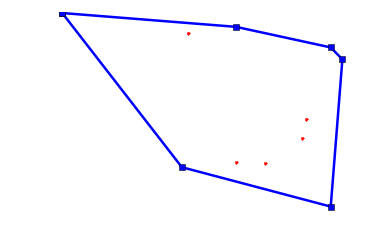

In [28]:
plot_convex_hull(Points(11))

Now the octagon and pacman shapes:

8 of 8 points on hull


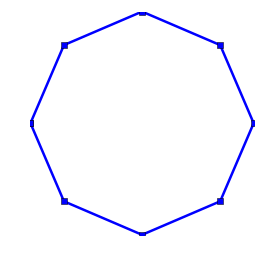

In [29]:
plot_convex_hull(octagon)

7 of 8 points on hull


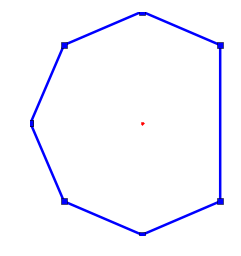

In [30]:
plot_convex_hull(pacman)

How about 100 random points?

15 of 100 points on hull


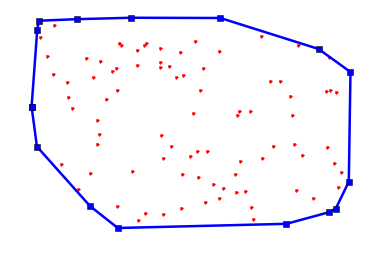

In [31]:
plot_convex_hull(Points(100))

Will 10,000 points be slow? 

In [32]:
P10K = Points(10000)

%timeit convex_hull(P10K)

1 loops, best of 3: 396 ms per loop


No problem! Still well under a second! Here's what it looks like:

27 of 10000 points on hull


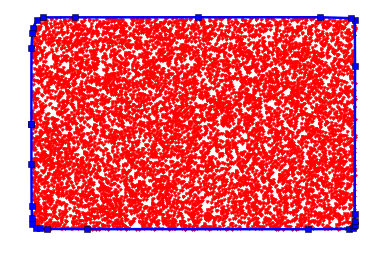

In [33]:
plot_convex_hull(P10K)

How about a non-random set? Here is a set of coordinates of 80 US cities:

9 of 80 points on hull


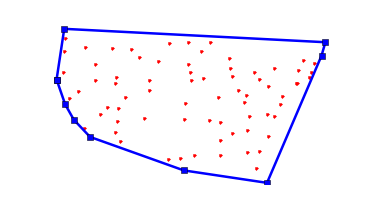

In [34]:
P = Point

USA = {
 P(-621, 289), P(-614, 297), P(-613, 319), P(-613, 342), P(-612, 263), 
 P(-612, 332), P(-603, 247), P(-599, 277), P(-592, 238), P(-591, 323), 
 P(-586, 229), P(-581, 289), P(-581, 305), P(-576, 253), P(-568, 260), 
 P(-563, 322), P(-560, 234), P(-560, 285), P(-559, 292), P(-558, 246),
 P(-557, 259), P(-555, 225), P(-549, 271), P(-543, 321), P(-535, 313), 
 P(-530, 249), P(-524, 278), P(-524, 288), P(-515, 308), P(-505, 206), 
 P(-504, 327), P(-492, 207), P(-488, 194), P(-488, 248), P(-487, 264), 
 P(-484, 305), P(-484, 328), P(-482, 297), P(-480, 289), P(-477, 210), 
 P(-470, 319), P(-468, 291), P(-462, 247), P(-461, 328), P(-452, 271), 
 P(-450, 210), P(-450, 226), P(-450, 245), P(-441, 311), P(-440, 301), 
 P(-438, 233), P(-438, 293), P(-431, 278), P(-425, 266), P(-423, 273),
 P(-422, 213), P(-422, 236), P(-420, 251), P(-415, 297), P(-413, 196), 
 P(-409, 214), P(-409, 290), P(-401, 181), P(-401, 253), P(-400, 230), 
 P(-400, 282), P(-394, 251), P(-394, 301), P(-387, 263), P(-385, 272), 
 P(-371, 285), P(-370, 285), P(-369, 299), P(-363, 309), P(-357, 292), 
 P(-355, 297), P(-352, 306), P(-344, 314), P(-340, 328), P(-608, 270)
 }

plot_convex_hull(USA)

A decidedly non-random set of points:

4 of 100 points on hull


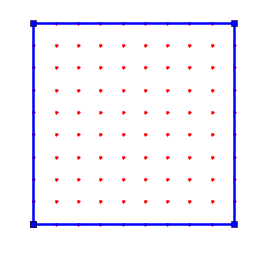

In [35]:
grid = {Point(x+0.5, y+0.5) 
        for x in range(10) for y in range(10)}

plot_convex_hull(grid)

A variant with some noise thrown in:

13 of 100 points on hull


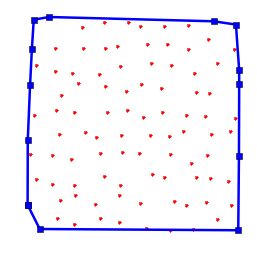

In [36]:
def noisy(points, d=0.3, seed=42): 
    "Add some uniform noise to each of the points."
    random.seed(seed)
    def noise(): return random.uniform(-d, +d)
    return {Point(x + noise(), y + noise())
            for (x, y) in points}

plot_convex_hull(noisy(grid))

Circles and donuts:

28 of 790 points on hull


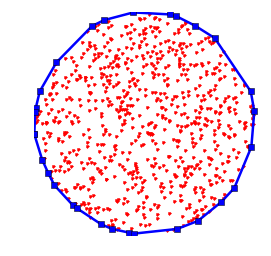

In [37]:
square = {Point(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(1000)}
circle = {p for p in square if p.x ** 2 + p.y ** 2 < 1}
plot_convex_hull(circle)

28 of 628 points on hull


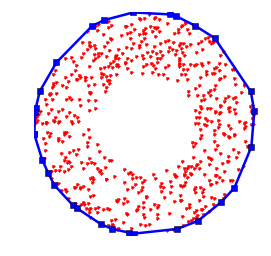

In [38]:
donut = {p for p in square if 0.2 < (p.x ** 2 + p.y ** 2) < 1}
plot_convex_hull(donut)

19 of 720 points on hull


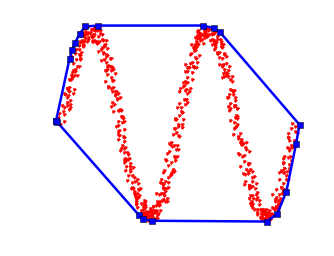

In [39]:
def rad(degrees): return degrees * math.pi / 180.0

sine = {Point(rad(d), 5 * math.sin(rad(d))) for d in range(720)}
plot_convex_hull(noisy(sine))

38 of 360 points on hull


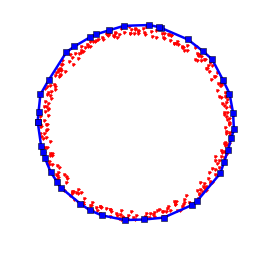

In [40]:
donut2 = noisy({Point(5 * math.sin(rad(d)), 5 * math.cos(rad(d))) for d in range(360)})

plot_convex_hull(donut2)

# Tests

So far, everything looks good! But I would gain even more confidence if we could pass a test suite:

In [41]:
def tests():
    # Tests of `turn`
    assert turn(octagon[0], octagon[1], octagon[2]) == 'left'
    assert turn(octagon[2], octagon[3], octagon[4]) == 'left'
    assert turn(octagon[1], octagon[0], octagon[7]) == 'right'
    assert turn(octagon[5], octagon[6], octagon[7]) == 'left'
    assert turn(octagon[2], octagon[1], octagon[0]) == 'right'
    assert turn(pacman[1], pacman[2], pacman[3]) == 'left'
    assert turn(pacman[3], pacman[4], pacman[5]) == 'right'
    assert turn(Point(0, 0), Point(0, 1), Point(0, 2)) == 'straight'
    assert turn(Point(2, 1), Point(3, 1), Point(4, 1)) == 'straight'
    assert turn(Point(2, 1), Point(4, 1), Point(3, 1)) == 'straight'
    assert turn(Point(0, 0), Point(1, 1), Point(2, 2)) == 'straight'
    assert turn(Point(0, 0), Point(-1, -1), Point(2, 2)) == 'straight'
    # More tests of `turn`, covering negative denominator
    A, B = Point(-2, -2), Point(0, 0)
    assert turn(A, B, Point(1, 3)) == 'left'
    assert turn(A, B, Point(2, 2)) == 'straight'
    assert turn(A, B, Point(3, 1)) == 'right'
    assert turn(A, B, Point(-1, 1)) == 'left'
    assert turn(A, B, Point(-1, -4)) == 'right'
    assert turn(A, B, Point(-1, -1)) == 'straight'
    assert turn(B, A, Point(-3, -4)) == 'left'
    assert turn(B, A, Point(-4, -3)) == 'right'
    assert turn(B, A, Point(-1, -1)) == 'straight'
    assert turn(B, A, Point(-3, -3)) == 'straight'
    
    # Tests of convex_hull
    assert convex_hull(octagon)== octagon
    assert convex_hull(circle) == convex_hull(donut)
    assert convex_hull(circle) == convex_hull(convex_hull(circle))
    for n in (0, 1, 2, 3):
        assert convex_hull(Points(n)) == Points(n)
    collinear = {Point(x, 0) for x in range(100)}
    assert convex_hull(collinear) == [min(collinear), max(collinear)]
    P = Point(5, 5)
    assert convex_hull(collinear | {P}) == [min(collinear), max(collinear), P]
    grid1 = {Point(x, y) for x in range(10) for y in range(10)}
    assert convex_hull(grid1) == [Point(0, 0), Point(9, 0), Point(9, 9), Point(0, 9)]

    return 'tests pass'
        
tests()

'tests pass'

## How Many Points on the Hull?

The number of points on the hull for `Points(N)` seems to increase slowly as `N` increases. 
How slowly? Let's try to find out.  We'll average the number of points on the hull for `Points(N)` over, say, 60 random trials:

In [42]:
def average_hull_size(N, trials=60):
    """Compute the average hull size of N random points
    (averaged over the given number of random trials)."""
    return sum(len(convex_hull(Points(N, seed=trials+i)))
               for i in range(trials)) / trials

We'll do this for several values of *N*, taken as powers of 2:

In [43]:
hull_sizes = [average_hull_size(2**e) 
              for e in range(14)]

print('   N   Hull Size')
for e in range(14): 
    print('{:4}: {:4.1f}'.format(2**e, hull_sizes[e]))

   N   Hull Size
   1:  1.0
   2:  2.0
   4:  3.7
   8:  5.1
  16:  7.1
  32:  8.6
  64: 11.0
 128: 12.6
 256: 14.6
 512: 16.4
1024: 18.1
2048: 19.8
4096: 21.6
8192: 23.2


Then we'll plot the results, with *N* on a log<sub>2</sub> scale:

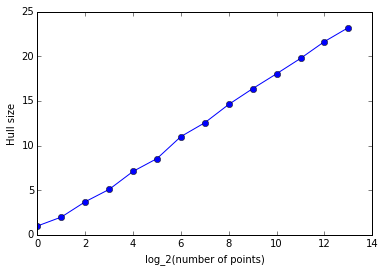

In [44]:
def plot_hull_sizes(hull_sizes):
    plt.plot(hull_sizes, 'bo-')
    plt.ylabel('Hull size')
    plt.xlabel('log_2(number of points)')

plot_hull_sizes(hull_sizes)

That sure looks like a straight line! 

That means we can define `estimated_hull_size` by computing a slope and intercept of the line. (I won't bother doing linear regression; I'll just draw a straight line from the first to the last point in `hull_sizes`.)

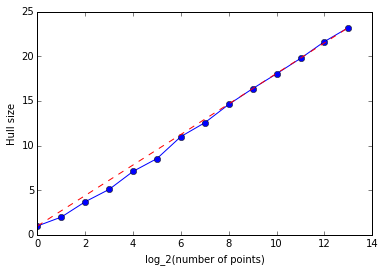

In [45]:
def estimated_hull_size(N):
    "Estimated hull size for N random points, (inter/extra)polating from hull_sizes."
    slope = (hull_sizes[-1] - hull_sizes[0]) / (len(hull_sizes) - 1)
    return hull_sizes[0] + slope * math.log(N, 2)

# Plot actual average hull sizes in blue, and estimated hull sizes in red
plot_hull_sizes(hull_sizes)
plt.plot([estimated_hull_size(2**e) 
          for e in range(len(hull_sizes))], 
         'r--');

Here's an estimate of the number of points on the hull of a quadrillion random points:

In [46]:
estimated_hull_size(10**15)

86.15634904778565

# Concluding Remarks and Further Reading

The convex hull problem is an interesting exercise in algorithm design.
The algorithm covered here is called  [Andrew's Monotone Chain](https://en.wikibooks.org/wiki/Algorithm_Implementation/Geometry/Convex_hull/Monotone_chain).
It is a variant of the [Graham Scan](https://en.wikipedia.org/wiki/Graham_scan).
You can read more from [Tamassia](http://cs.brown.edu/courses/cs016/docs/old_lectures/ConvexHull-Notes.pdf) or [Wikipedia](https://en.wikipedia.org/wiki/Convex_hull).